## Libras (PTBR Hand Signal Language) Translation Video to Text

### Manual Image Data Generation for Later use (NN Classifier)

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp
import random
import os
import glob
from IPython.display import clear_output

In [2]:
import sys
sys.path.append('C:/Users/Mafeus/Desktop/Git_Repos/OpenCV')
import OpCV_Utils

In [3]:
import tkinter as tk
import tkinter.simpledialog

In [8]:
def hand_detection(frame, results, mpDraw, mpHands):
    
    for handLandmarks in results.multi_hand_landmarks:
            
        landmarks_list = []
            
        for id, lm in enumerate(handLandmarks.landmark):
            h, w, c = frame.shape
            cX, cY  = int(lm.x*w), int(lm.y*h)
                
            cv2.circle(frame, (cX, cY), 6, (205, 0, 0), cv2.FILLED)
            cv2.putText(frame, '{}'.format(id), (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (150, 0, 0), 1)
                
            landmarks_list.append([id, cX, cY])
            
        mpDraw.draw_landmarks(frame, handLandmarks, mpHands.HAND_CONNECTIONS)
        #mpDraw.draw_landmarks(bboard, handLandmarks, mpHands.HAND_CONNECTIONS)
                
        return landmarks_list

In [14]:
# Manual Data Collection (press Y to freeze frame and write letter classification):

# Object Instances:
mpDraw = mp.solutions.drawing_utils
mpHands = mp.solutions.hands

hands = mpHands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.4, min_tracking_confidence=0.4)
hands_mirror = mpHands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.4, min_tracking_confidence=0.4)
hands_rotated = mpHands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.4, min_tracking_confidence=0.4)

thumb         = [1, 2, 3, 4]
index_finger  = [5, 6, 7, 8]
middle_finger = [9, 10, 11, 12]
ring_finger   = [13, 14, 15, 16]
pinky_finger  = [17, 18, 19, 20]

main = tk.Tk()
main.withdraw()

# Load Video:
# cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture('http://192.168.0.106:8080/video')
video_fps = cap.get(cv2.CAP_PROP_FPS)

img_libras = cv2.imread('libras.jpeg')

while True:
    
    os.chdir('C:/Users/Mafeus/Desktop/Git_Repos/OpenCV/Libras (PTBR) Recognition Method')
    
    start = time.time()
    
    success, frame = cap.read()
            
    if not success:
        print('Server OFF')
        break
        
    # Adjust Img from Camera
    frame = cv2.resize(frame, (0,0), None, 0.8, 0.8)
    frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    # frame = cv2.flip(frame, -1)
                    
    #####################################################################################################################
    
    results = hands.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    
    frame_mirror = cv2.flip(frame, 1)
    results_mirror = hands_mirror.process(cv2.cvtColor(frame_mirror, cv2.COLOR_BGR2RGB))
        
    frame_rotated = OpCV_Utils.img_rotation(frame, random.randint(1,20), (frame.shape[1]//2, frame.shape[0]//2))
    results_rotated = hands.process(cv2.cvtColor(frame_rotated, cv2.COLOR_BGR2RGB))
    
    frame_to_save = frame.copy()
    frame_mirror_to_save = frame_mirror.copy()
    frame_rotated_to_save = frame_rotated.copy()
    
    if results.multi_hand_landmarks:
        landmarks_list = hand_detection(frame, results, mpDraw, mpHands)
        
    if results_mirror.multi_hand_landmarks:
        landmarks_list = hand_detection(frame_mirror, results_mirror, mpDraw, mpHands)
        
    if results_rotated.multi_hand_landmarks:
        landmarks_list = hand_detection(frame_rotated, results_rotated, mpDraw, mpHands)
                                
    frame_stack = OpCV_Utils.stackImgs([[frame, frame_mirror, frame_rotated, img_libras]], scale = 0.8, sep_lines=True)
                
    #####################################################################################################################
    
    # Keyboard Controls:
    
    key = cv2.waitKey(1) or 0xff   
        
    if key == ord('k'):
        break
        
    if key == ord('p'):       
        cv2.waitKey(0)
        
    if key == ord('y'):
        
        try:
            class_name = tkinter.simpledialog.askstring('Define Class', 'Define Class: ')
            
            folder_path = 'C:/Users/Mafeus/Desktop/libras_dataset_mdp/C'
            
            os.chdir(folder_path)

            cv2.imwrite(class_name + '.png', frame_to_save)
            cv2.imwrite(class_name + '_mirror.png', frame_mirror_to_save)
            cv2.imwrite(class_name + '_rotated.png', frame_rotated_to_save)

            cv2.waitKey(0)
            
        except:
            print('Not Saved')
       
    os.chdir('C:/Users/Mafeus/Desktop/Git_Repos/OpenCV/Libras (PTBR) Recognition Method')    
    
    end = time.time()

    frame_time = (end - start) + 0.0001
    fps = np.floor(1/frame_time)
            
    # cv2.putText(frame, "FPS: {}".format(fps), (9,20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    cv2.imshow("Output", frame_stack)
    
cv2.destroyAllWindows()
cap.release()

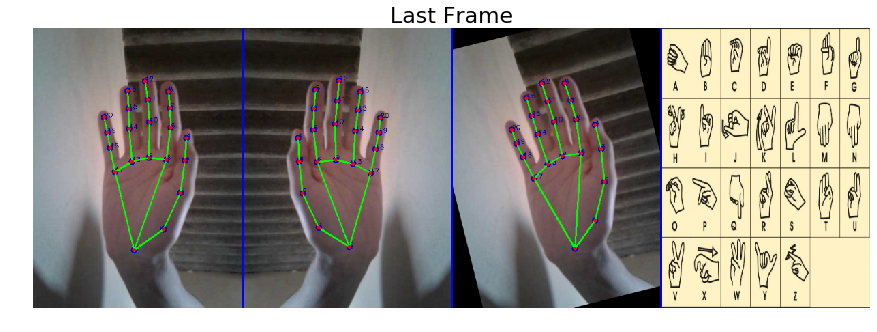

In [11]:
OpCV_Utils.show_single_img_plt(cv2.cvtColor(frame_stack, cv2.COLOR_BGR2RGB), 'Last Frame', fig_size=(15,15))

### Create Data Variations with random shifts and rotations:

In [15]:
# letters = ['C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']

letters = ['C']

for letter in letters:
    
    dataset_path = 'C:/Users/Mafeus/Desktop/libras_dataset_mdp'
    imgs = glob.glob(dataset_path + '/' + letter + '/*.png')
    l_name = 'extra_' + letter + '_'
    folder_path = 'C:/Users/Mafeus/Desktop/libras_dataset_mdp/' + letter

    for i, img in enumerate(imgs):

        read_img = cv2.imread(img)

        name = l_name + str(i+1)

        os.chdir(folder_path)

        for j in range(7):

            img_transformed = OpCV_Utils.img_rotation(read_img.copy(), random.randint(-5,5), (read_img.shape[1]//2, read_img.shape[0]//2))
            img_transformed = OpCV_Utils.img_translation(img_transformed, random.randint(-20,20), random.randint(-20,20))
            cv2.imwrite(name + str(j) + '.png', img_transformed)

            clear_output(wait=True)
            print(letter, ' - Count:', j, i)

    os.chdir('C:/Users/Mafeus/Desktop/Git_Repos/OpenCV/Libras (PTBR) Recognition Method')  

C  - Count: 6 29
